In [420]:
# Main data packages. 
import numpy as np
import pandas as pd

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [432]:
df = pd.read_csv('data/neueFische_Wetter.csv')

In [433]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87672 entries, 0 to 87671
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        87672 non-null  object 
 1   temp        87672 non-null  float64
 2   feels_like  87672 non-null  float64
 3   pressure    87672 non-null  int64  
 4   humidity    87672 non-null  int64  
 5   clouds      87672 non-null  int64  
 6   visibility  84921 non-null  float64
 7   wind_speed  87672 non-null  float64
 8   wind_deg    87672 non-null  int64  
 9   wind_gust   30566 non-null  float64
 10  rain_1h     14258 non-null  float64
 11  snow_1h     1046 non-null   float64
 12  weather_id  87672 non-null  int64  
dtypes: float64(7), int64(5), object(1)
memory usage: 8.7+ MB


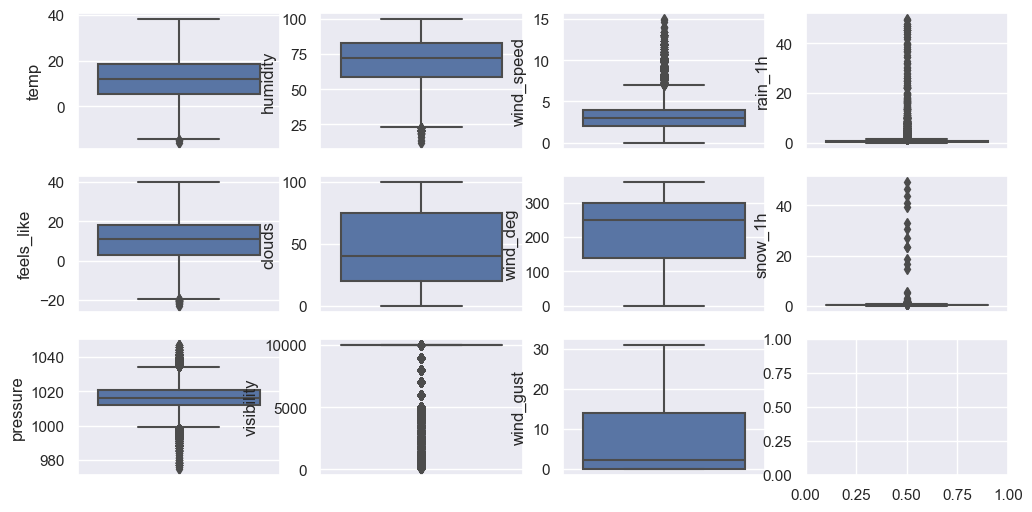

In [435]:
sns.set()
fig, axes = plt.subplots(3,4)
ax=int(0)
ay=int(0)
ay2=0
for e in ['temp', 'feels_like', 'pressure', 'humidity', 'clouds',
       'visibility', 'wind_speed', 'wind_deg', 'wind_gust', 'rain_1h',
       'snow_1h']:  
       sns.boxplot(data=df, y=e, ax=axes[ay,ax])
       ax+=1
       ay2+=1
       ay=int(ay2%3)
       ax=int(ax-ay/4)

In [436]:
df.tail()

,time,temp,feels_like,pressure,humidity,clouds,visibility,wind_speed,wind_deg,wind_gust,rain_1h,snow_1h,weather_id
87667,2021-12-31 20:00:00 +01:00,13.15,12.48,1020,75,70,NaN,1.34,243,2.68,0.25,NaN,500
87668,2021-12-31 21:00:00 +01:00,13.79,13.08,1020,71,57,NaN,1.34,239,3.58,NaN,NaN,803
87669,2021-12-31 22:00:00 +01:00,14.38,13.68,1020,69,93,NaN,2.68,309,4.02,NaN,NaN,804
87670,2021-12-31 23:00:00 +01:00,14.58,13.87,1020,68,0,10000.0,3.13,208,4.02,1.52,NaN,501
87671,2022-01-01 00:00:00 +01:00,14.48,13.73,1021,67,0,10000.0,4.02,187,8.05,1.52,NaN,501


In [437]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,87672.0,12.155226,8.632749,-15.77,5.35,11.89,18.62,38.11
feels_like,87672.0,10.876790,9.774918,-22.77,3.18,11.03,18.29,40.04
pressure,87672.0,1016.465143,8.097692,975.00,1012.00,1016.00,1021.00,1047.00
humidity,87672.0,70.286066,16.109694,12.00,59.00,72.00,83.00,100.00
clouds,87672.0,42.673077,32.650085,0.00,20.00,40.00,75.00,100.00
visibility,84921.0,9296.869373,2045.574641,50.00,10000.00,10000.00,10000.00,10000.00
wind_speed,87672.0,3.132998,1.987412,0.00,2.00,3.00,4.00,15.00
wind_deg,87672.0,215.922290,97.071699,0.00,140.00,250.00,300.00,360.00
wind_gust,30566.0,6.116232,7.105029,0.00,0.00,2.24,14.00,31.00
rain_1h,14258.0,0.861530,2.704707,0.10,0.19,0.32,0.73,49.78


In [442]:
# Turn wind data into sensible format
df["wind_dir_x"] = df.wind_deg.apply(lambda x: np.cos(np.array(x) * np.pi /180))
df["wind_dir_y"] = df.wind_deg.apply(lambda x: np.sin(np.array(x) * np.pi /180))

In [443]:
df.wind_gust.fillna(df.wind_speed,inplace=True)
df.rain_1h.fillna(0,inplace=True)
df.snow_1h.fillna(0,inplace=True)

In [444]:
df.describe().round(2)

,temp,feels_like,pressure,humidity,clouds,visibility,wind_speed,wind_deg,wind_gust,rain_1h,snow_1h,weather_id,wind_dir_x,wind_dir_y
count,87672.00,87672.00,87672.00,87672.00,87672.00,84921.00,87672.00,87672.00,87672.00,87672.00,87672.00,87672.00,87672.00,87672.00
mean,12.16,10.88,1016.47,70.29,42.67,9296.87,3.13,215.92,4.06,0.14,0.01,728.97,0.03,-0.23
std,8.63,9.77,8.10,16.11,32.65,2045.57,1.99,97.07,4.66,1.14,0.41,127.79,0.67,0.71
min,-15.77,-22.77,975.00,12.00,0.00,50.00,0.00,0.00,0.00,0.00,0.00,200.00,-1.00,-1.00
25%,5.35,3.18,1012.00,59.00,20.00,10000.00,2.00,140.00,1.00,0.00,0.00,701.00,-0.64,-0.87
50%,11.89,11.03,1016.00,72.00,40.00,10000.00,3.00,250.00,3.00,0.00,0.00,800.00,0.14,-0.50
75%,18.62,18.29,1021.00,83.00,75.00,10000.00,4.00,300.00,4.11,0.00,0.00,802.00,0.64,0.50
max,38.11,40.04,1047.00,100.00,100.00,10000.00,15.00,360.00,31.00,49.78,49.28,804.00,1.00,1.00


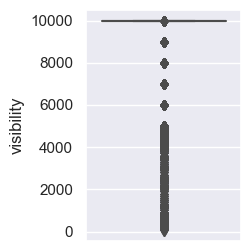

In [445]:
fig, ax = plt.subplots(figsize = (2, 3))
sns.boxplot(y=df.visibility, ax=ax)
plt.show()


Input Weather Codes

In [446]:
codes = pd.read_csv('data/neueFische_Wettercodes.csv')
codes.columns = ['weather_id', 'WeatherMain', 'WeatherDescription']

In [447]:
df = pd.merge(df, codes,how='left',on='weather_id')

Extract year, month, day, hour

In [448]:
df.time = df.apply(lambda x: pd.to_datetime(x['time'],utc=True),axis=1)
df = df.assign(
    #timestamp = lambda x: pd.to_datetime(x['time'],utc=True), 
    date = lambda x: x['time'].dt.date,
    year = lambda x: x['time'].dt.year,
    month = lambda x: x['time'].dt.month,
    week = lambda x: x['time'].dt.isocalendar().week,
    day = lambda x: x['time'].dt.day,
    weekday = lambda x: x['time'].dt.weekday,
    dayofyear = lambda x: x['time'].dt.dayofyear,
    hour = lambda x: x['time'].dt.hour,
)
df.weekday.replace({0:'Mo',
                    1:'Tu',
                    2:'We',
                    3:'Th',
                    4:'Fr',
                    5:'Sa',
                    6:'Su'},inplace=True)

In [449]:
df.head()

,time,temp,feels_like,pressure,humidity,clouds,visibility,wind_speed,wind_deg,wind_gust,...,WeatherMain,WeatherDescription,date,year,month,week,day,weekday,dayofyear,hour
0,2012-01-01 00:00:00+00:00,2.43,2.43,1017,77,75,4200.0,1.0,90,1.0,...,Clouds,broken clouds: 51-84%,2012-01-01,2012,1,52,1,Su,1,0
1,2012-01-01 01:00:00+00:00,2.43,2.43,1017,77,75,4200.0,1.0,90,1.0,...,Snow,light snow,2012-01-01,2012,1,52,1,Su,1,1
2,2012-01-01 02:00:00+00:00,0.96,-2.82,1017,80,75,10000.0,3.6,180,3.6,...,Snow,light snow,2012-01-01,2012,1,52,1,Su,1,2
3,2012-01-01 03:00:00+00:00,2.22,2.22,1017,91,90,4700.0,1.0,220,1.0,...,Rain,light rain,2012-01-01,2012,1,52,1,Su,1,3
4,2012-01-01 04:00:00+00:00,2.22,2.22,1017,91,90,4700.0,1.0,220,1.0,...,Rain,light rain,2012-01-01,2012,1,52,1,Su,1,4


In [450]:
daytaframe = df.groupby('date').agg('mean')
dyf = daytaframe

<AxesSubplot:xlabel='month', ylabel='rain_1h'>

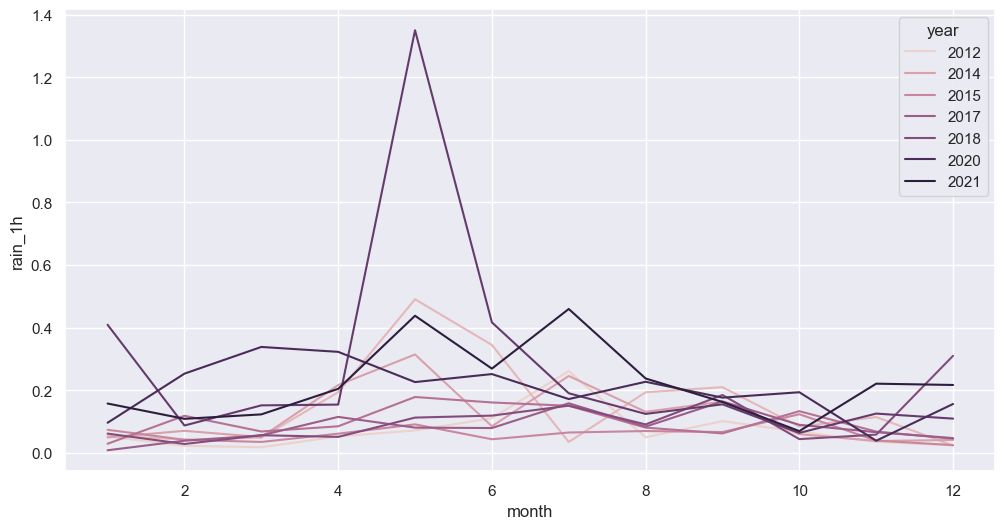

In [451]:
sns.lineplot(data=df.groupby(['year','month']).agg('mean'), x='month', y='rain_1h',hue='year')

<AxesSubplot:xlabel='month', ylabel='snow_1h'>

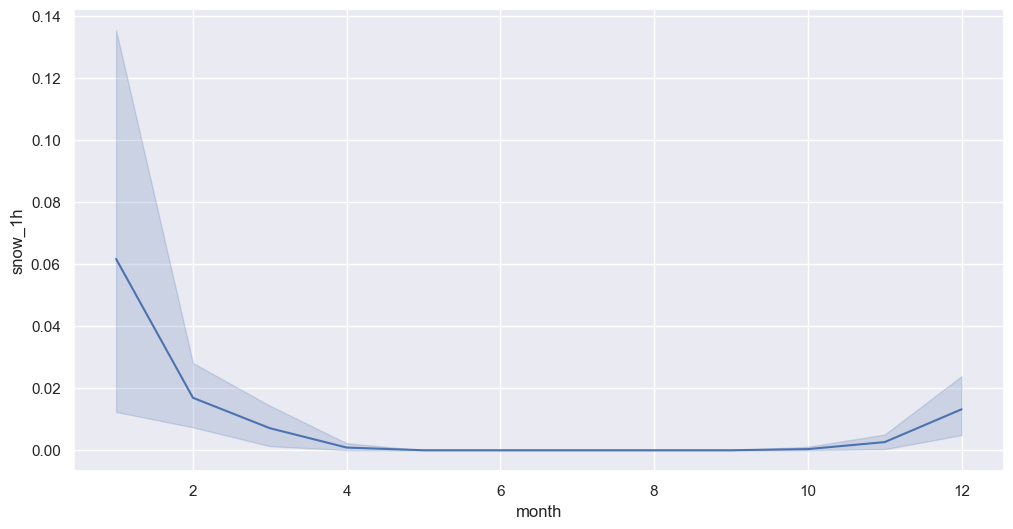

In [452]:
sns.lineplot(data=df.groupby(['year','month']).agg('mean'), x='month', y='snow_1h')#,hue='year')

<AxesSubplot:xlabel='month', ylabel='feels_like'>

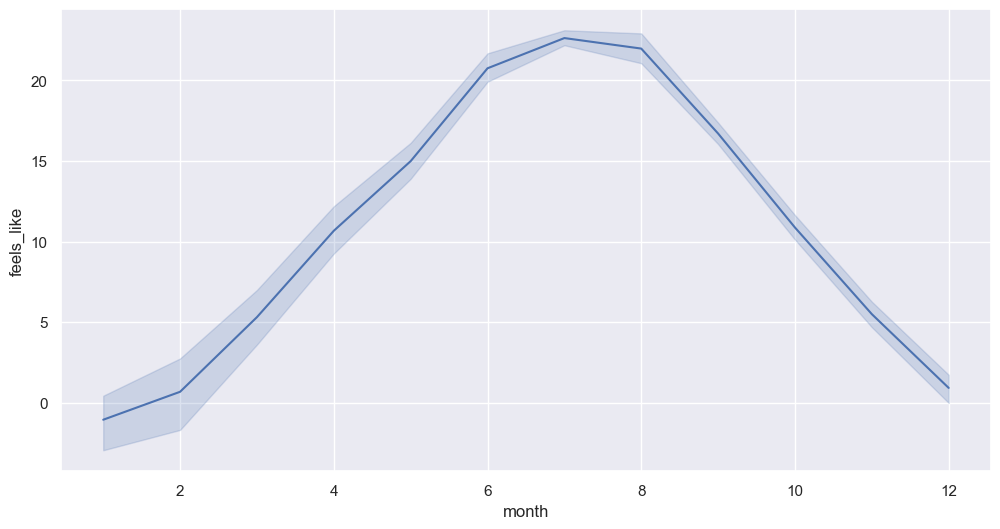

In [459]:
sns.lineplot(data=df.groupby(['year','month']).agg('mean'), x='month', y='feels_like')#,hue='year')

In [454]:
winddata = pd.DataFrame(df[['wind_speed','wind_deg']].value_counts().reset_index())

In [455]:
winddata.columns = ['wind_speed', 'wind_deg', 'frequency']

In [419]:
import plotly.express as px
fig = px.bar_polar(winddata.query('frequency>4'), r='frequency', theta="wind_deg",
                   color="wind_speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   log_r=True)
fig.show()